In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression 

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

import mlflow
from mlflow.models import infer_signature

In [2]:
data_path = 'creditcard.csv'
df = pd.read_csv(data_path)

In [3]:
# Next we will split the new dataset into Features and Target
X = df.drop(columns="Class", axis=1)
y = df["Class"]

In [4]:
# Split the new dataset into training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=0)

print("Training sets:\nX_train: {} y_train:{}".format(X_train.shape, y_train.shape))
print("\nTesting sets:\nX_test: {} y_test:{}".format(X_test.shape, y_test.shape))

Training sets:
X_train: (227845, 30) y_train:(227845,)

Testing sets:
X_test: (56962, 30) y_test:(56962,)


In [5]:
# fit the scaler on the entire data frame so that it standardizes all of the data in the same way. 
scaler = StandardScaler()
scaler.fit(X)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Logistic Regression as the classification algorithm.

Balanced accuracy mean:0.930
Logistic: f1 score=0.109 auc score=0.739


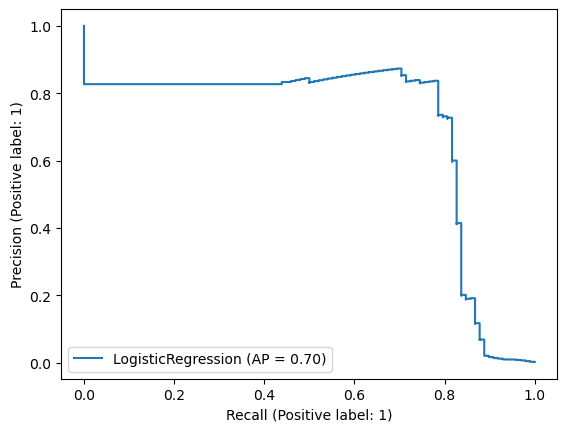

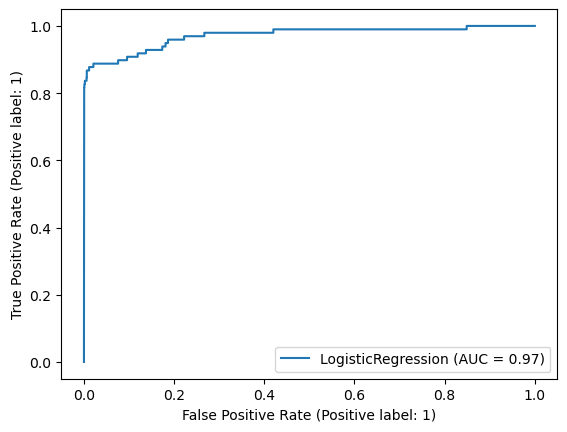

Model run:  494af47968d6411f830202bd8c21759f


/Users/yingfan/anaconda3/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [6]:
experiment_id = mlflow.create_experiment("scikit_learn_experiment")
experiment = mlflow.get_experiment(experiment_id)

with mlflow.start_run():
    
    model = make_pipeline(SMOTE(random_state=0), LogisticRegression(max_iter=1000))
    
    cv_results = cross_validate(model, X_train, y_train, scoring="balanced_accuracy",
    return_train_score=True, return_estimator=True, n_jobs=-1)
    
    accuracy_scores = []
    f1_scores = []
    auc_scores = []

    for fold_id, cv_model in enumerate(cv_results["estimator"]):
    
        y_pred = cv_model.predict(X_test)
    
        accuracy_scores.append(balanced_accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
    
        # predict probabilities    
        y_probs = cv_model.predict_proba(X_test)
        y_probs = y_probs[:, 1]
    
        precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

        auc_scores.append(auc(recall, precision))

    # summarize scores
    mlflow.log_metric("Balanced accuracy mean", np.mean(accuracy_scores))
    print(f"Balanced accuracy mean:" f"{np.mean(accuracy_scores):.3f}")
    
    mlflow.log_metric("f1 score", np.mean(f1_scores))
    mlflow.log_metric("auc score", np.mean(auc_scores))
    print('Logistic: f1 score=%.3f auc score=%.3f' % (np.mean(f1_scores), np.mean(auc_scores)))   
    
    PrecisionRecallDisplay.from_estimator(cv_model, X_test, y_test, name="LogisticRegression")
    plt.savefig("Precision-Recall_curve.png")
    plt.show() 
    mlflow.log_artifact("Precision-Recall_curve.png")

        
    RocCurveDisplay.from_estimator(cv_model, X_test, y_test, name="LogisticRegression")
    plt.savefig("Roc_curve.png")
    plt.show()    
    mlflow.log_artifact("Roc_curve.png")
    
    # https://www.mlflow.org/docs/latest/models.html#how-to-log-models-with-signatures
    signature = infer_signature(X_train, cv_model.predict(X_train))
    
    mlflow.sklearn.log_model(cv_model, "log_reg_model", signature=signature)
    
    print("Model run: ", mlflow.active_run().info.run_uuid)
    
mlflow.end_run()        

In [7]:
# move terminal to the same directory that contians mlruns and type mlflow ui -p 1234
# open a browser and type in http://localhost:1234 or http://127.0.0.1:1234. 
# Then you will see the MLflow UI.

In [8]:
loaded_model = mlflow.sklearn.load_model("runs:/494af47968d6411f830202bd8c21759f/log_reg_model")

In [9]:
loaded_model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

# Hyperparameter tuning

In [10]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [11]:
c_values = [100, 10, 1.0, 0.1, 0.01]

C:100.000
Balanced accuracy mean:0.930
Logistic: f1 score=0.109 auc score=0.739


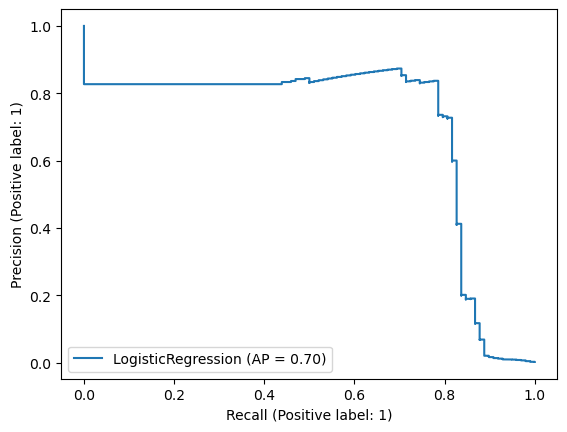

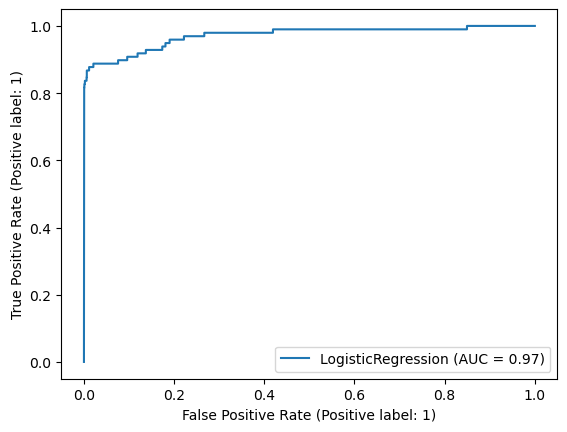

Model run:  20cdb6aeafa547c69db3369d827b97c9
C:10.000
Balanced accuracy mean:0.930
Logistic: f1 score=0.109 auc score=0.739


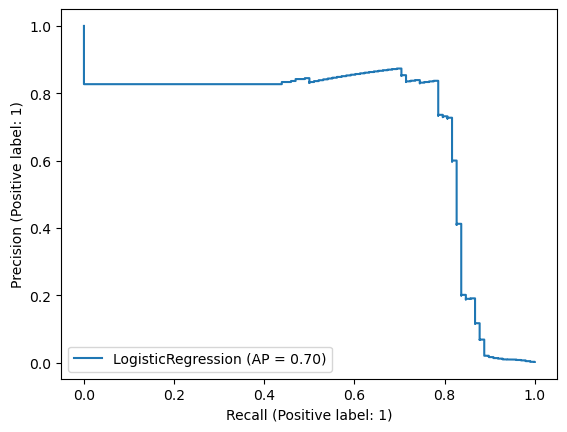

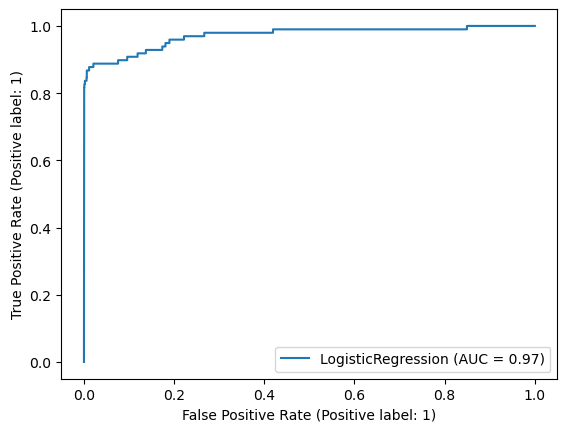

Model run:  737bd2752d4745488d41c5f430d73f7a
C:1.000
Balanced accuracy mean:0.930
Logistic: f1 score=0.109 auc score=0.739


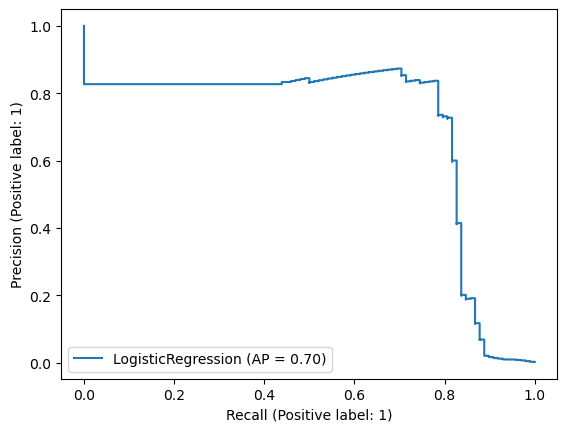

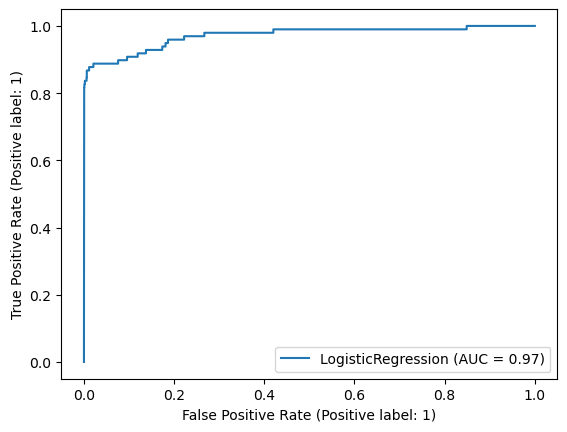

Model run:  1005fe7849484edfa63496dbff6f1108
C:0.100
Balanced accuracy mean:0.931
Logistic: f1 score=0.109 auc score=0.735


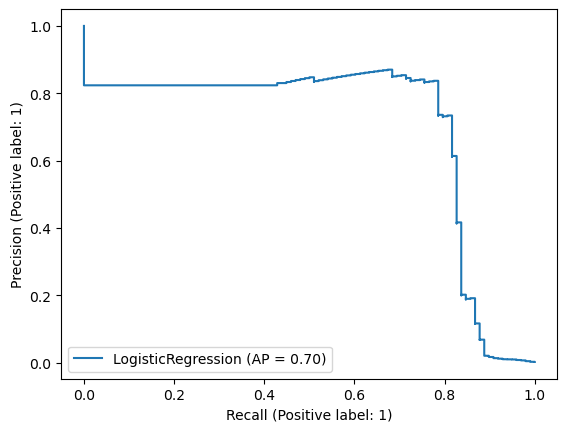

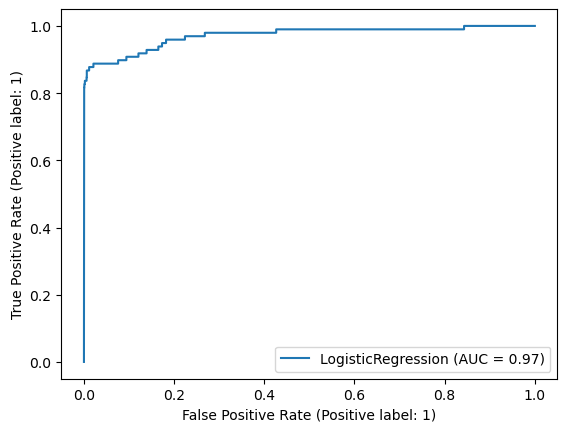

Model run:  86f80a8ba4e3465cbee7773516754cd8
C:0.010
Balanced accuracy mean:0.931
Logistic: f1 score=0.111 auc score=0.715


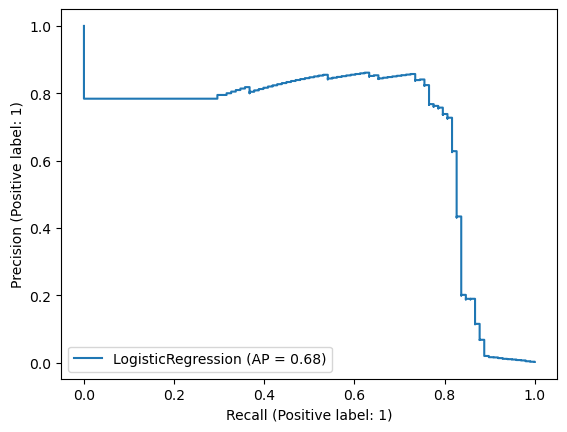

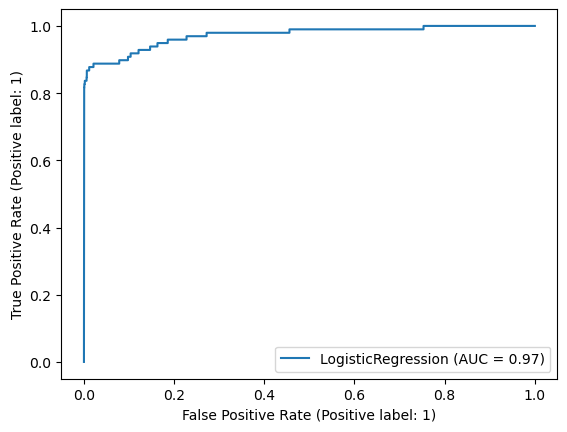

Model run:  7aac833077f04830bb7e9e5e0bf950c1


In [12]:
experiment_id = mlflow.create_experiment("scikit_learn_hyperparameter_tuning")
experiment = mlflow.get_experiment(experiment_id)
    
for C in c_values:
        
    with mlflow.start_run():
    
        model = make_pipeline(SMOTE(random_state=0), LogisticRegression(C=C))
    
        mlflow.log_param("c value", C)
        print(f"C:" f"{C:.3f}")
    
        cv_results = cross_validate(model, X_train, y_train, scoring="balanced_accuracy",
        return_train_score=True, return_estimator=True, n_jobs=-1)
    
        accuracy_scores = []
        f1_scores = []
        auc_scores = []

        for fold_id, cv_model in enumerate(cv_results["estimator"]):
        
            y_pred = cv_model.predict(X_test)

            accuracy_scores.append(balanced_accuracy_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))
        
            # predict probabilities    
            y_probs = cv_model.predict_proba(X_test)
            y_probs = y_probs[:, 1]
    
            precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

            auc_scores.append(auc(recall, precision))
        
        # summarize scores
        mlflow.log_metric("Balanced accuracy mean", np.mean(accuracy_scores))
        print(f"Balanced accuracy mean:" f"{np.mean(accuracy_scores):.3f}")
    
        mlflow.log_metric("f1 score", np.mean(f1_scores))
        mlflow.log_metric("auc score", np.mean(auc_scores))
        print('Logistic: f1 score=%.3f auc score=%.3f' % (np.mean(f1_scores), np.mean(auc_scores)))   
    
        PrecisionRecallDisplay.from_estimator(cv_model, X_test, y_test, name="LogisticRegression")
        plt.savefig("Precision-Recall_curve.png")
        plt.show() 
        mlflow.log_artifact("Precision-Recall_curve.png")
     
        RocCurveDisplay.from_estimator(cv_model, X_test, y_test, name="LogisticRegression")
        plt.savefig("Roc_curve.png")
        plt.show()    
        mlflow.log_artifact("Roc_curve.png")
    
        # https://www.mlflow.org/docs/latest/models.html#how-to-log-models-with-signatures
        signature = infer_signature(X_train, cv_model.predict(X_train))
    
        mlflow.sklearn.log_model(cv_model, "log_reg_model", signature=signature)
    
        print("Model run: ", mlflow.active_run().info.run_uuid)    
            
    mlflow.end_run()    